# Downloading and Unzip the dataset



In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sentiment-analysis-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F989445%2F1808590%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240418%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240418T100155Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D69116a18dcd7ff5e246708bde38d203bc0b48be33ec06779a1cf72a3db360ac647492ae28b0b7936573e7076fe1b9febc584c2470f1a69ca85ece40ed69678270508d092fdd57183233e4ea1c223e1414e518615336b8cf9ee495f55a0c0baa2dfebc6daf1a26dc8652bd550a67e0bce0a7356c36d55e3f6e71c20e517fc408d2f54a2ed41adf247ccbed65ad3745c4f9a6b41f67457d2176dd80c3c40312c367efa9fb493ea0026a501e06159d15f721492b6fb29d4bfb007bf29b913dc7292ebde1df2b44c1790e71fb6ce36117b0f1809391bd24f10f785470e7afbe2e06f3847967e0dc1e6452b08ee3200abc88b49ce091fc39d0d7ef275065faa22ae80'

KAGGLE_INPUT_PATH = '/kaggle/input'
KAGGLE_WORKING_PATH = '/kaggle/working'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
    os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
    pass
try:
    os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
    pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
                with ZipFile(tfile) as zfile:
                    zfile.extractall(destination_path)
            else:
                with tarfile.open(tfile.name) as tarfile:
                    tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 57092644 bytes downloaded
Downloaded and uncompressed: sentiment-analysis-dataset
Data source import complete.


# Importing Required Libraries

In [2]:
"""## Twitter Sentiment Analysis"""

import nltk

nltk.download()

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re
import warnings

warnings.filterwarnings('ignore')


NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package bcp47 to /root/nltk_data...
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package bllip_wsj_no_aux to /root/nltk_data...
       |   Unzipping models/bllip_wsj_no_aux.zip.
       | Downloading package book_grammars to /root/nltk_data...
       |   Un


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


# Preparing the dataset

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

d = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/train.csv',encoding='latin1');
f = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/test.csv',encoding='latin1');
df = pd.concat([d,f])
print(df.shape)
display(df.info())
display(df)

/kaggle/input/sentiment-analysis-dataset/testdata.manual.2009.06.14.csv
/kaggle/input/sentiment-analysis-dataset/test.csv
/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv
/kaggle/input/sentiment-analysis-dataset/train.csv
(32296, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 32296 entries, 0 to 4814
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            31015 non-null  object 
 1   text              31014 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         31015 non-null  object 
 4   Time of Tweet     31015 non-null  object 
 5   Age of User       31015 non-null  object 
 6   Country           31015 non-null  object 
 7   Population -2020  31015 non-null  float64
 8   Land Area (Km²)   31015 non-null  float64
 9   Density (P/Km²)   31015 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.7+ MB


None

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0
...,...,...,...,...,...,...,...,...,...,...
4810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,sentiment,selected_text
0,neutral,"I`d have responded, if I were going"
1,negative,Sooo SAD
2,negative,bullying me
3,negative,leave me alone
4,negative,"Sons of ****,"
...,...,...
27476,negative,d lost
27477,negative,", don`t force"
27478,positive,Yay good for both of you.
27479,positive,But it was worth it ****.


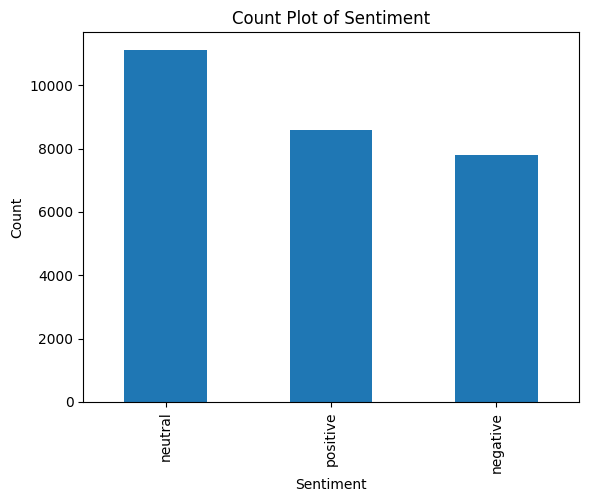

0

In [5]:
df = df[['sentiment', 'selected_text']]
df = df.dropna()
display(df)
#df['sentiment'] = df['sentiment'].replace({'positive': 1, 'neutral': 0, 'negative': -1})

# """#### Visualizing the count"""

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
sentiment_counts = df["sentiment"].value_counts()

# Plotting
sentiment_counts.plot(kind='bar')
plt.title("Count Plot of Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


df.isna().sum().sum()

Number of missing values: 0


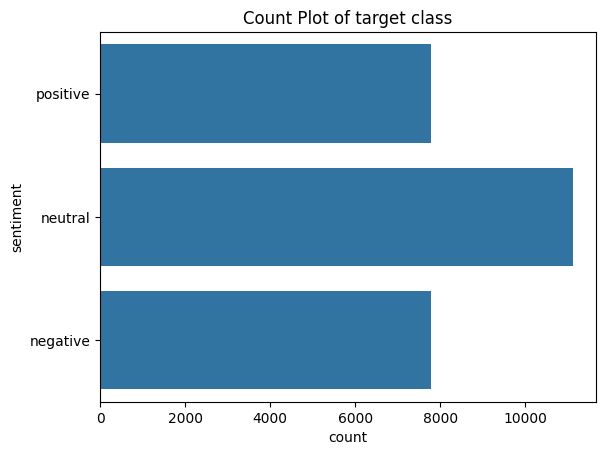

In [6]:
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns

print("Number of missing values:", df.isna().sum().sum())

# Assuming df_positive, df_neutral, and df_negative are defined DataFrames
df_positive = df[df['sentiment'] == 'positive']
df_neutral = df[df['sentiment'] == 'neutral']
df_negative = df[df['sentiment'] == 'negative']

min_class_size = min(len(df_positive), len(df_neutral), len(df_negative))

# Downsample the larger classes to match the size of the smallest class
df_positive_downsampled = resample(df_positive, replace=False, n_samples=min_class_size, random_state=1234)
df_negative_downsampled = resample(df_negative, replace=False, n_samples=min_class_size, random_state=1234)

# Concatenate the downsampled dataframes with the original neutral dataframe
df_downsampled = pd.concat([df_positive_downsampled, df_neutral, df_negative_downsampled])

# Plotting
sns.countplot(df_downsampled["sentiment"])
plt.title("Count Plot of target class")
plt.show()

# Dataset Preprocessing

In [7]:
"""## Data Preprocessing

1. removing stop words
2. removing punctuations
3. Lemmatizing
4. removing tags
5. removing special characters
6. lowercase conversion
"""

# Data Preprocessing
lemmatizer = WordNetLemmatizer()

corpus = df['selected_text'].tolist()
final_corpus = []

for text in corpus:
    if not isinstance(text, str):
        text = str(text)
    # Remove special characters, tags, punctuations, and numbers
    text = re.sub('<.*?>', '', text)
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Convert to lowercase
    text = text.lower()

    # Tokenize the text
    words = word_tokenize(text)

    # Lemmatize and remove stopwords
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]

    # Join the words back into a string
    text = " ".join(words)
    final_corpus.append(text)

# Create DataFrames
data_cleaned = pd.DataFrame()
data_cleaned["selected_text"] = final_corpus
data_cleaned["sentiment"] = df["sentiment"].values

data_eda = pd.DataFrame()
data_eda['selected_text'] = final_corpus
data_eda['sentiment'] = df["sentiment"].values

# Extracting all text from each sentiment class
positive = data_eda[data_eda['sentiment'] == 'positive']
positive_all = " ".join(positive['selected_text'])

neutral = data_eda[data_eda['sentiment'] == 'neutral']
neutral_all = " ".join(neutral['selected_text'])

negative = data_eda[data_eda['sentiment'] == 'negative']
negative_all = " ".join(negative['selected_text'])


Word Cloud

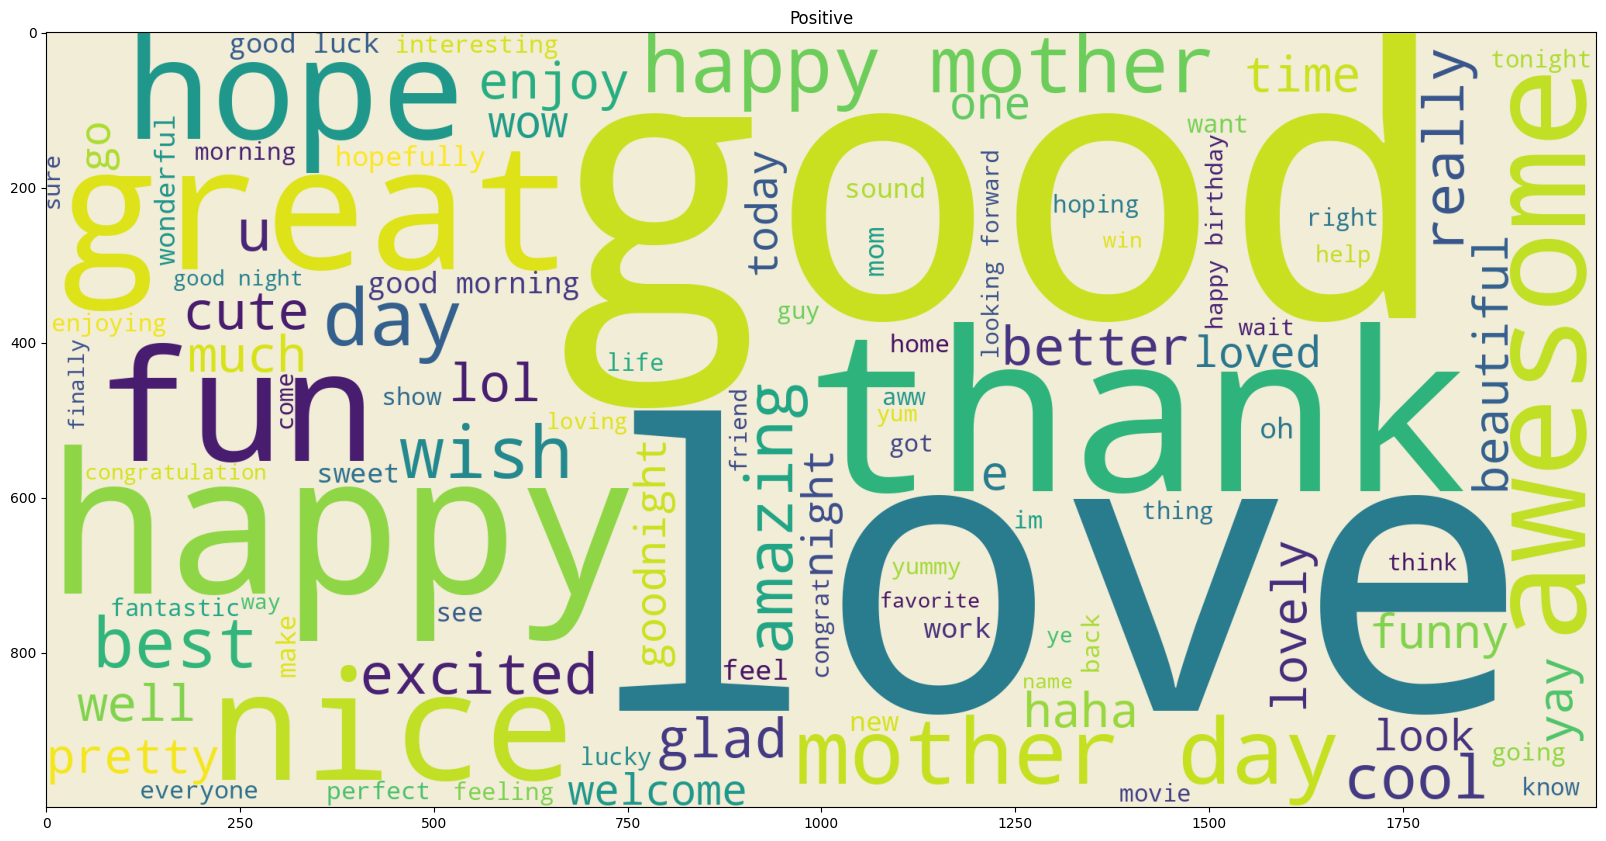

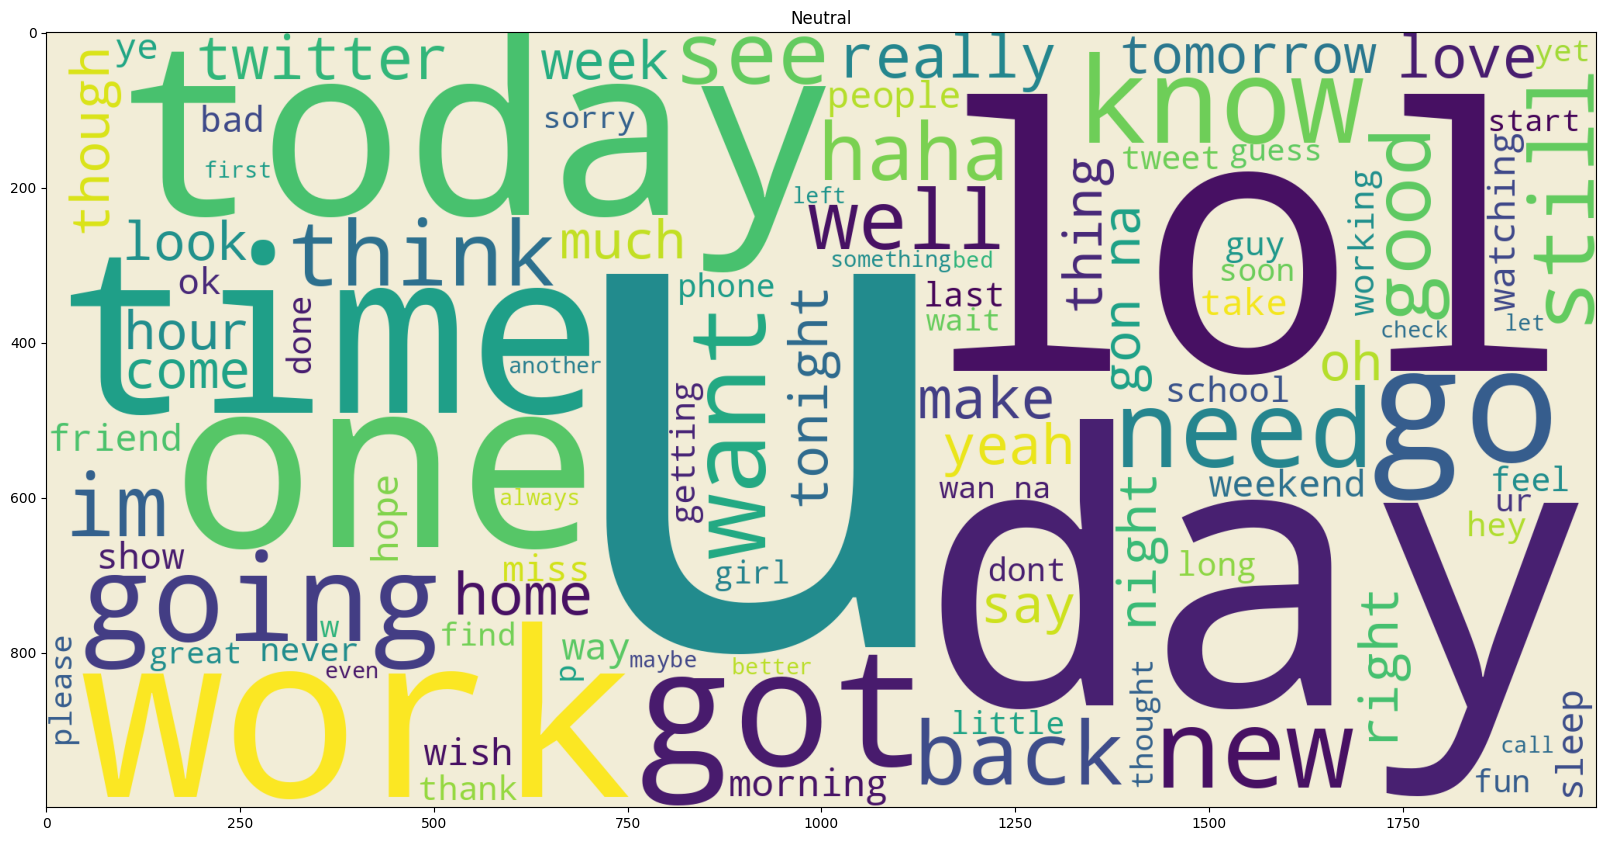

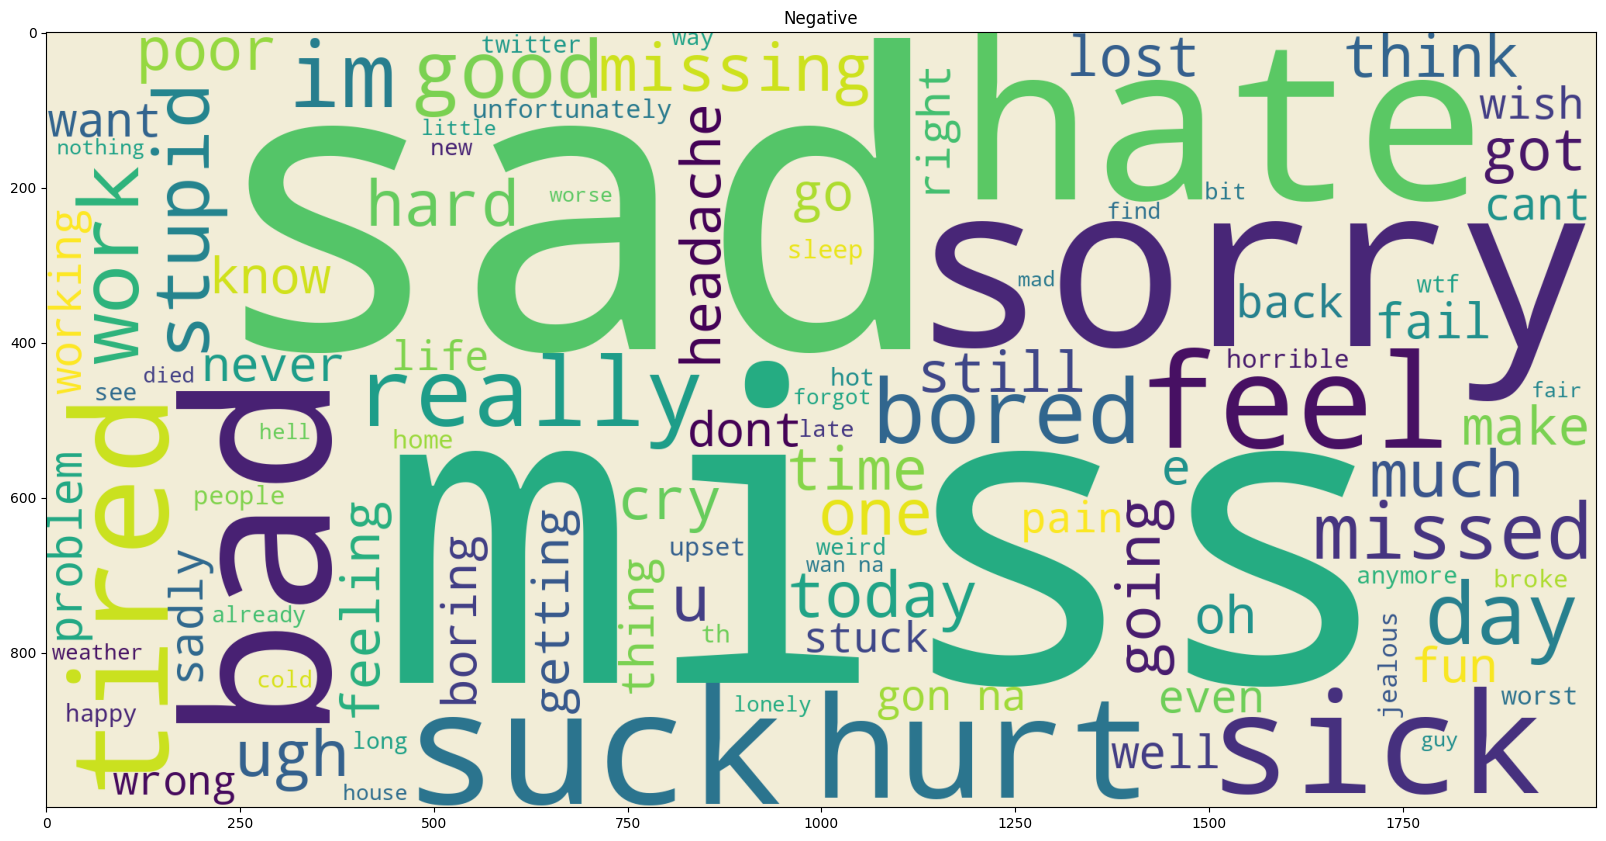

In [8]:
"""#### Word Cloud Positive data"""

from wordcloud import WordCloud

wordcloud = WordCloud(width=2000,
                      height=1000,
                      background_color='#F2EDD7FF',
                      max_words=100).generate(positive_all)

plt.figure(figsize=(20, 30))
plt.imshow(wordcloud)
plt.title("Positive")
plt.show()

"""#### Word Cloud Neutral data"""

wordcloud = WordCloud(width=2000,
                      height=1000,
                      background_color='#F2EDD7FF',
                      max_words=100).generate(neutral_all)

plt.figure(figsize=(20, 30))
plt.imshow(wordcloud)
plt.title("Neutral")
plt.show()

"""#### Word Cloud Negative data"""

wordcloud = WordCloud(width=2000,
                      height=1000,
                      background_color='#F2EDD7FF',
                      max_words=100).generate(negative_all)

plt.figure(figsize=(20, 30))
plt.imshow(wordcloud)
plt.title("Negative")
plt.show()



Inference

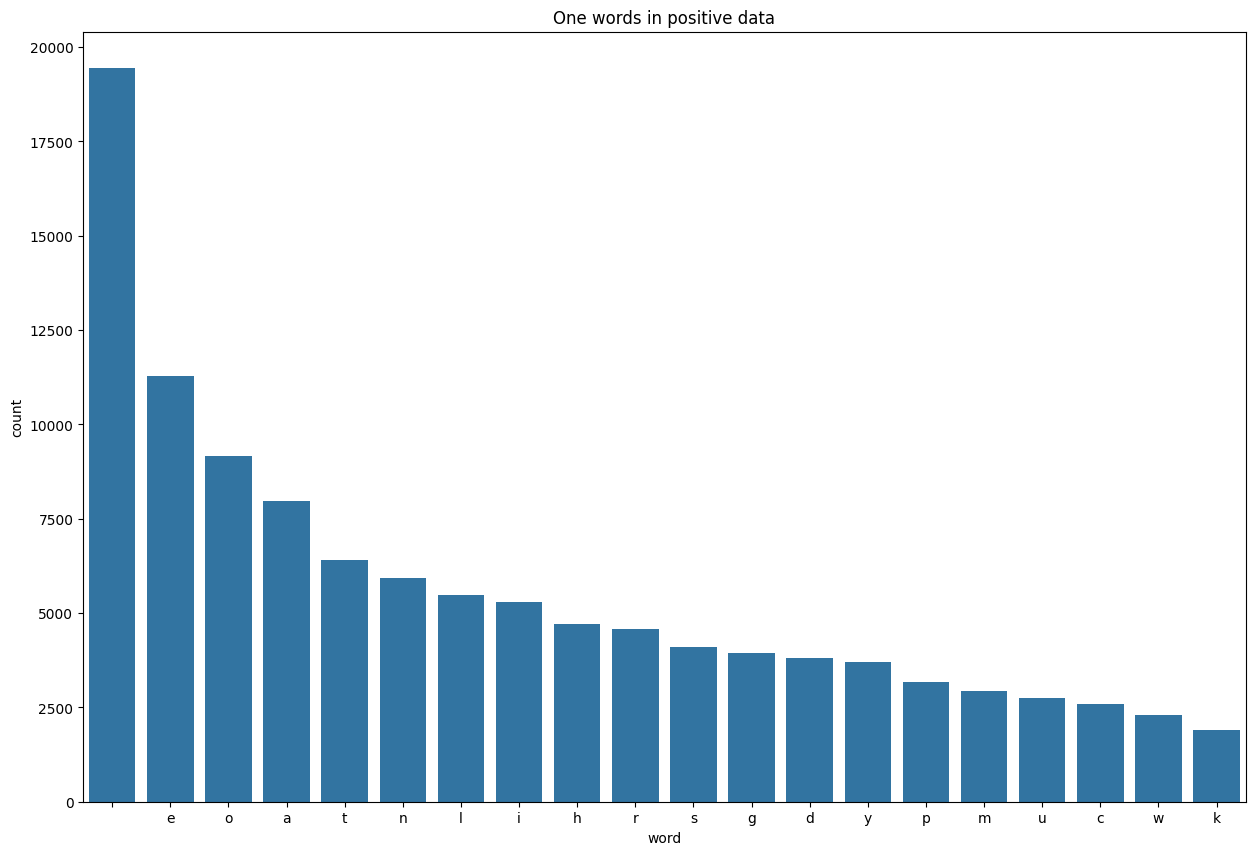

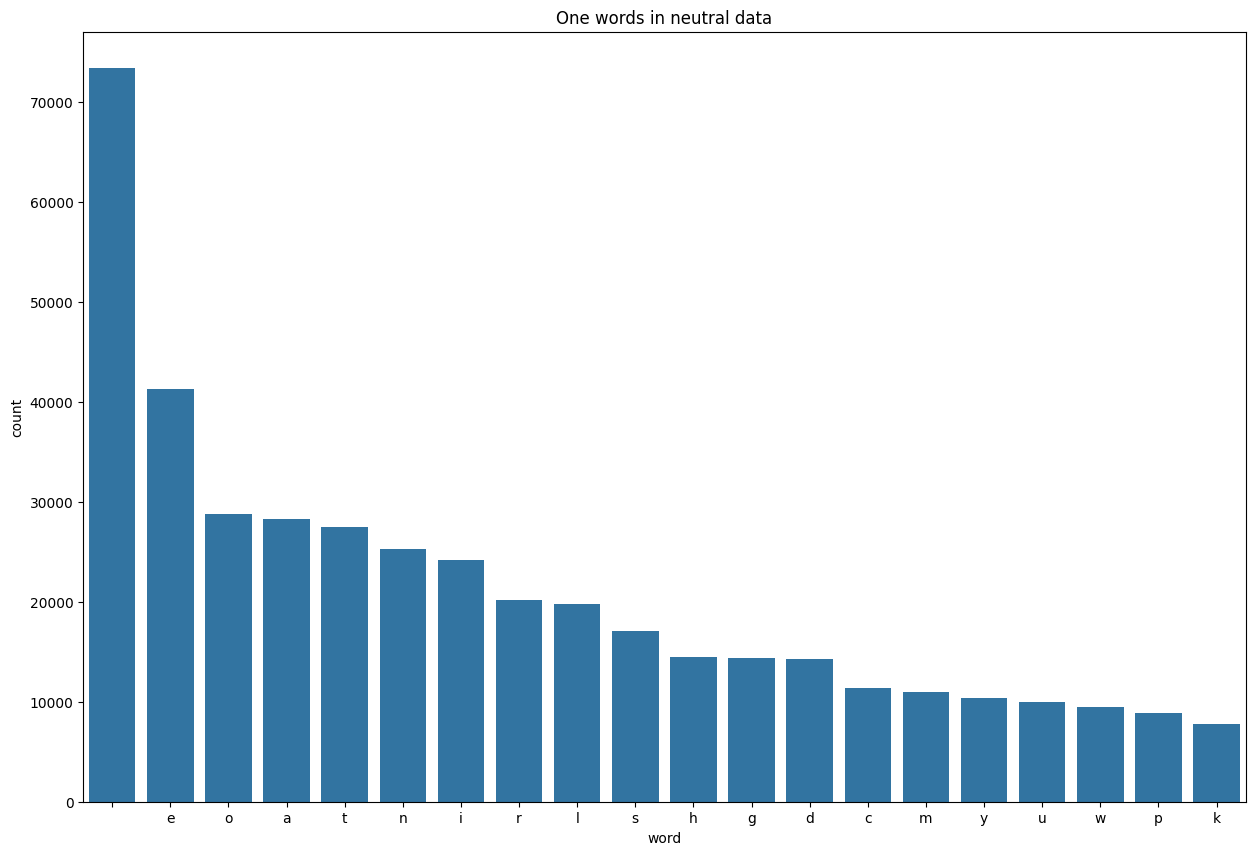

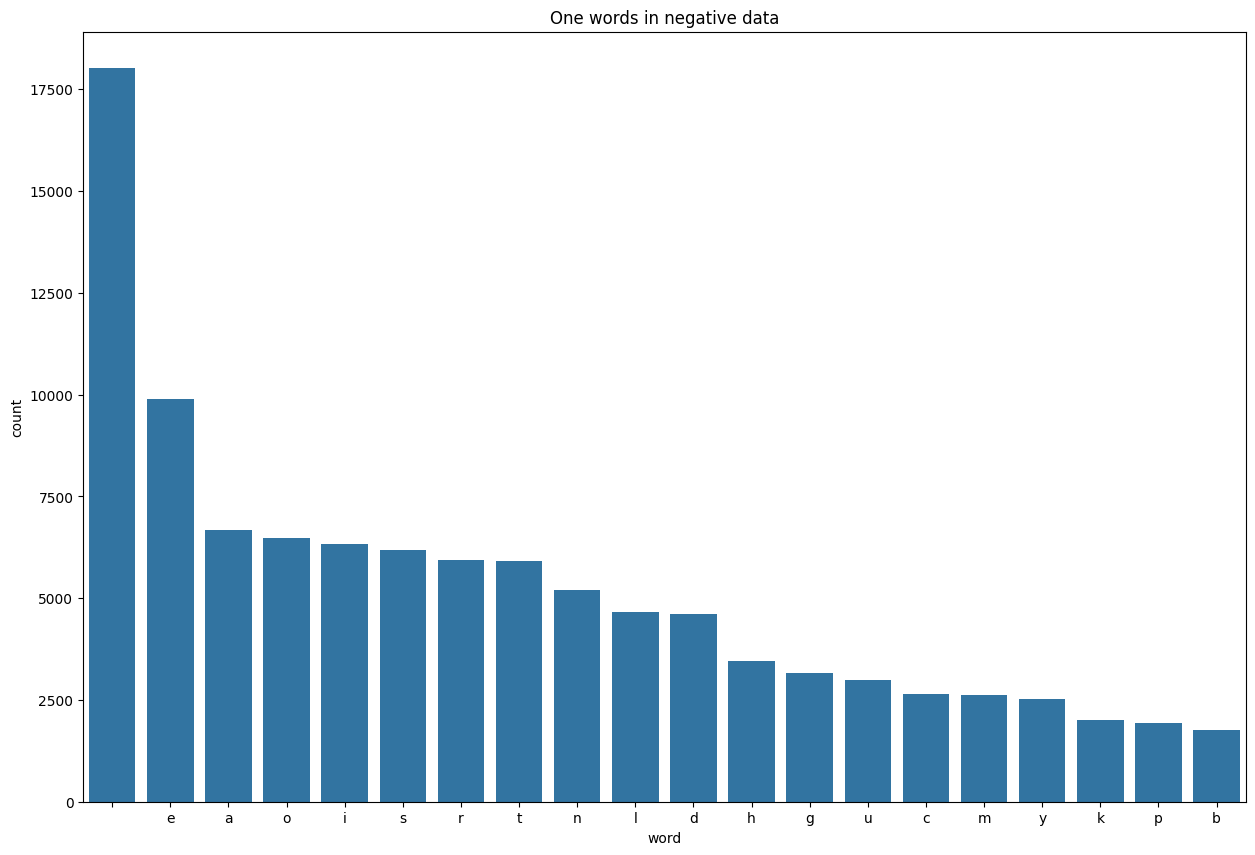

"**Inference**\n* Positive data has words like good, day, thanks, great, happy.\n* Neutral data doesn't seem to have any distinct words.\n* Negative data has words like work, miss, sad, etc."

In [9]:
"""**Inference:**
* Positive data has words like Thank, love, LOL, Haha etc.
* Neutral data doesn't seem to have any distinct words.
* Negative data has words like work, sad, tired, suck sorry, etc.
Some of the words are still common in both such as LOL, quot.

#### One-word count
"""

def get_count(data):
    dic = {}
    for i in data:
        for j in i:
            if j not in dic:
                dic[j] = 1
            else:
                dic[j] += 1
    return dic

count_corpus = get_count(positive_all)
count_corpus = pd.DataFrame({"word": count_corpus.keys(), "count": count_corpus.values()})
count_corpus = count_corpus.sort_values(by="count", ascending=False)

plt.figure(figsize=(15, 10))
sns.barplot(x=count_corpus["word"][:20], y=count_corpus["count"][:20])
plt.title('One words in positive data')
plt.show()

count_corpus = get_count(neutral_all)
count_corpus = pd.DataFrame({"word": count_corpus.keys(), "count": count_corpus.values()})
count_corpus = count_corpus.sort_values(by="count", ascending=False)

plt.figure(figsize=(15, 10))
sns.barplot(x=count_corpus["word"][:20], y=count_corpus["count"][:20])
plt.title('One words in neutral data')
plt.show()

count_corpus = get_count(negative_all)
count_corpus = pd.DataFrame({"word": count_corpus.keys(), "count": count_corpus.values()})
count_corpus = count_corpus.sort_values(by="count", ascending=False)

plt.figure(figsize=(15, 10))
sns.barplot(x=count_corpus["word"][:20], y=count_corpus["count"][:20])
plt.title('One words in negative data')
plt.show()

"""**Inference**
* Positive data has words like good, day, thanks, great, happy.
* Neutral data doesn't seem to have any distinct words.
* Negative data has words like work, miss, sad, etc."""

# Evaluating Models

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("Training Accuracy:", round(accuracy_score(y_train, y_train_pred), 2))
    print("Testing Accuracy:", round(accuracy_score(y_test, y_test_pred), 2))

    print("\nClassification Report (Training):")
    print(classification_report(y_train, y_train_pred))

    print("\nClassification Report (Testing):")
    print(classification_report(y_test, y_test_pred))

    print("\nConfusion Matrix (Training):")
    ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred).plot()

    print("\nConfusion Matrix (Testing):")
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred).plot()

# TF-IDF Vectorization
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(data_cleaned['selected_text'])

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, data_cleaned['sentiment'], test_size=0.2, random_state=42)



Naive Bayes:
Training Accuracy: 0.86
Testing Accuracy: 0.78

Classification Report (Training):
              precision    recall  f1-score   support

    negative       0.95      0.73      0.83      6209
     neutral       0.78      0.96      0.86      8881
    positive       0.93      0.85      0.89      6894

    accuracy                           0.86     21984
   macro avg       0.88      0.85      0.86     21984
weighted avg       0.87      0.86      0.86     21984


Classification Report (Testing):
              precision    recall  f1-score   support

    negative       0.87      0.60      0.71      1572
     neutral       0.72      0.89      0.80      2236
    positive       0.82      0.79      0.80      1688

    accuracy                           0.78      5496
   macro avg       0.80      0.76      0.77      5496
weighted avg       0.79      0.78      0.77      5496


Confusion Matrix (Training):

Confusion Matrix (Testing):


Linear SVM:
Training Accuracy: 0.93
Testing Accu

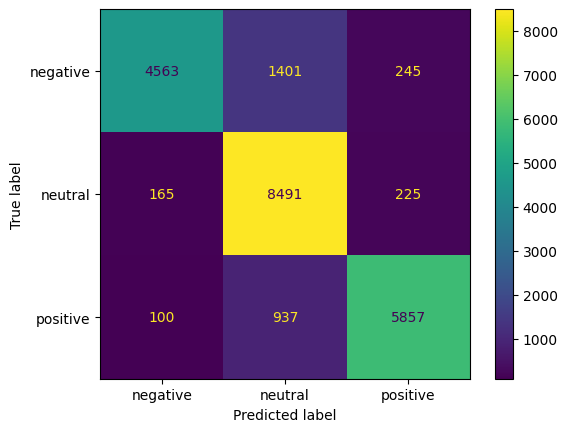

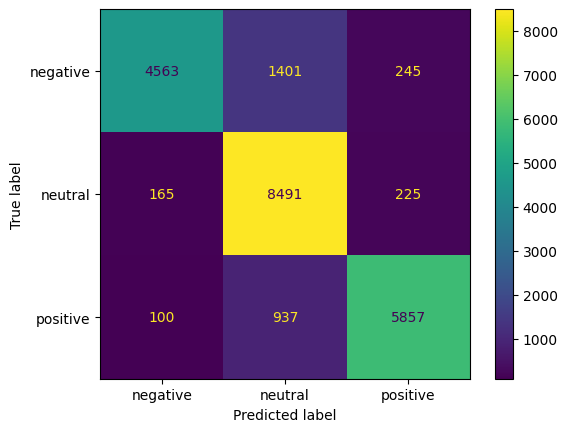

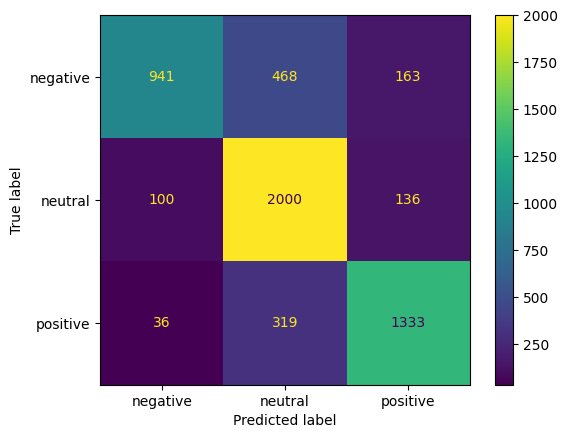

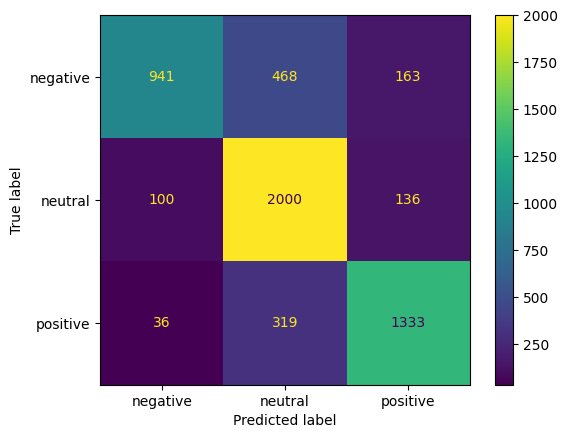

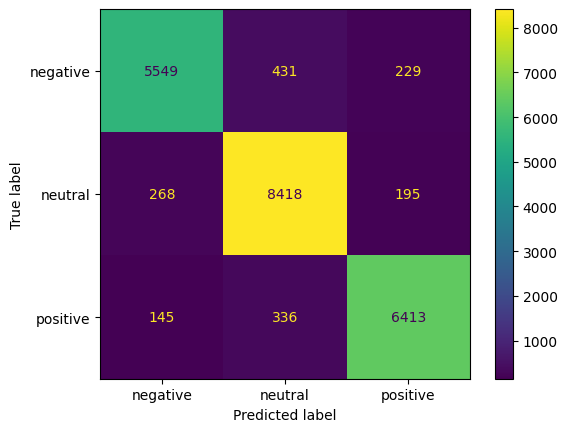

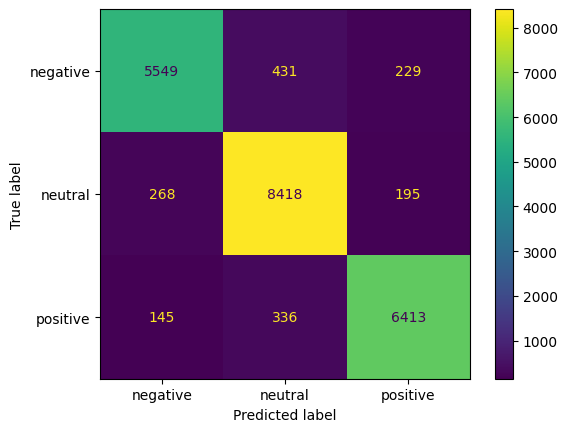

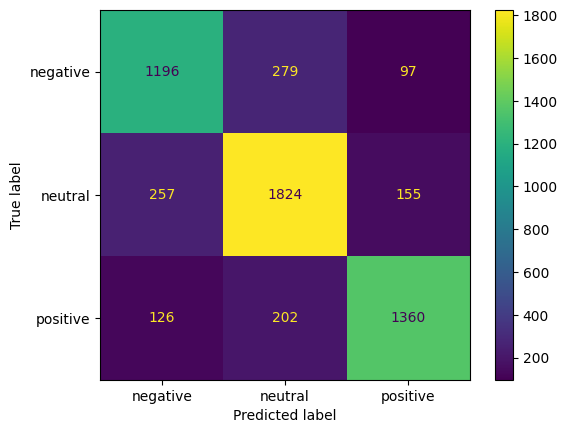

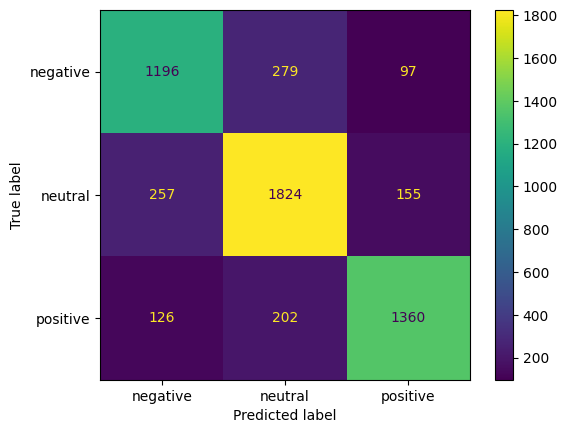

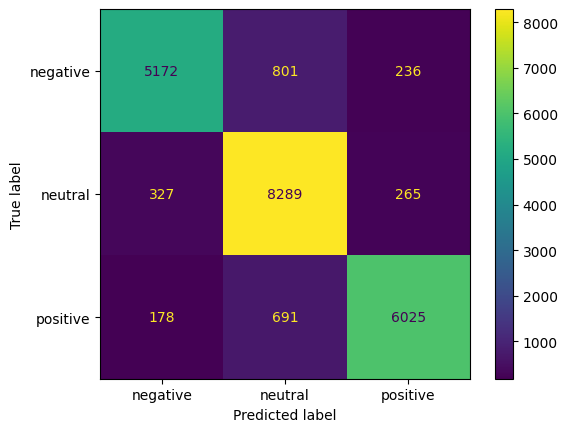

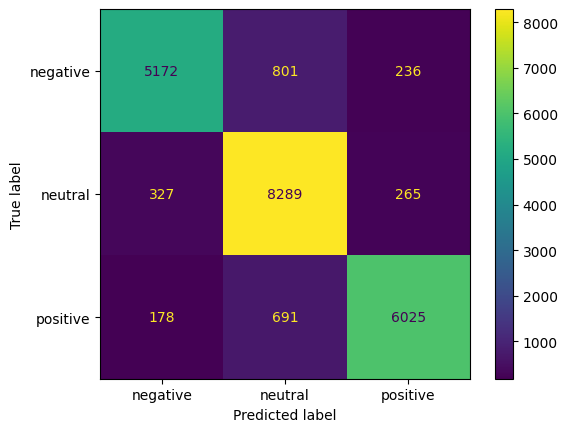

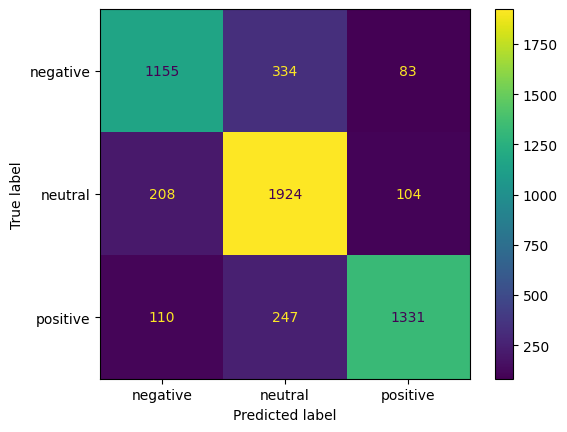

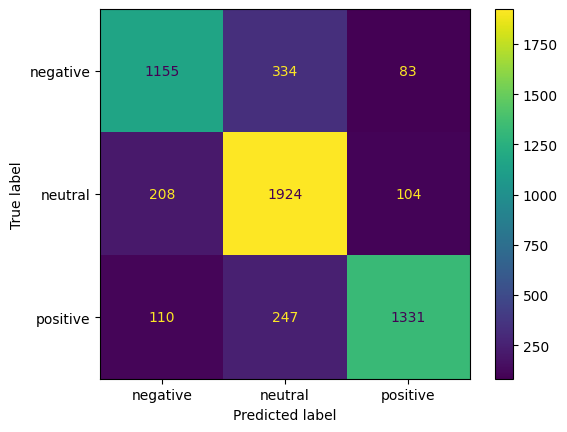

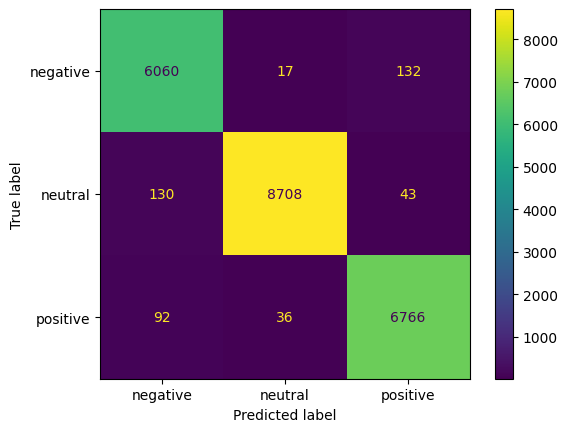

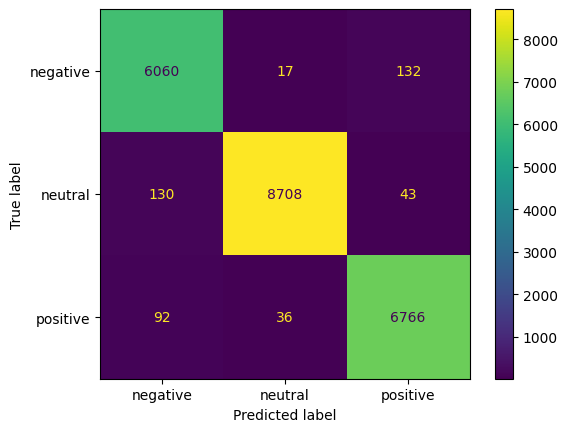

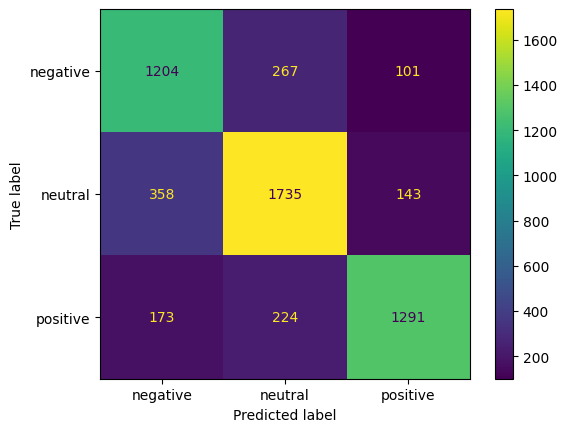

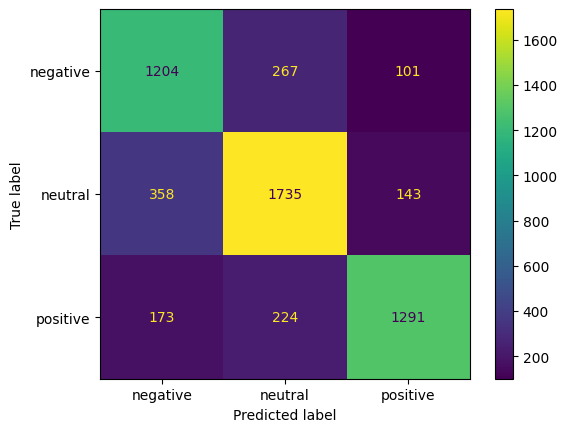

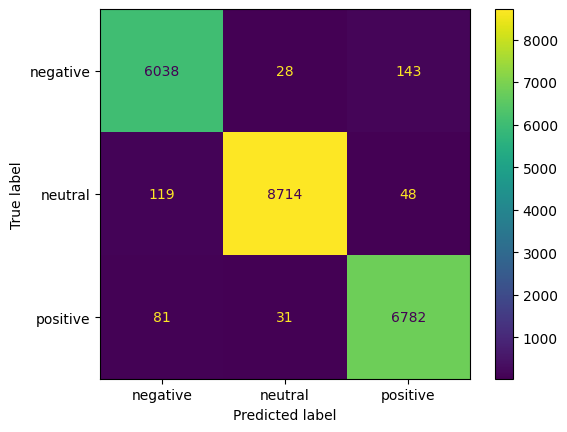

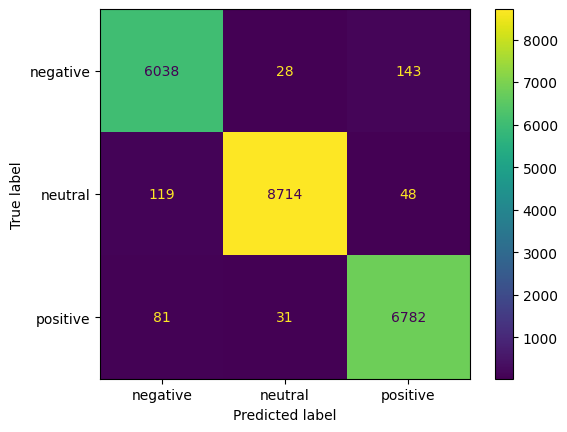

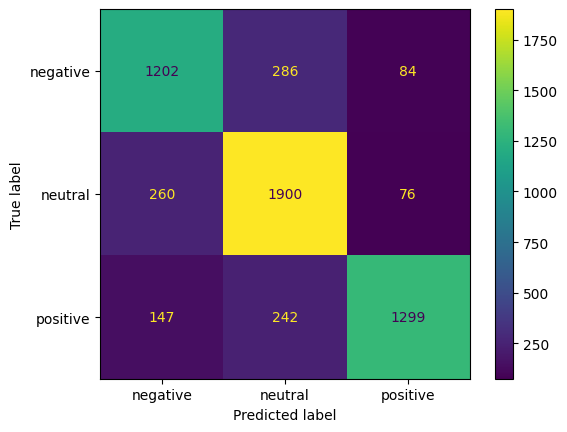

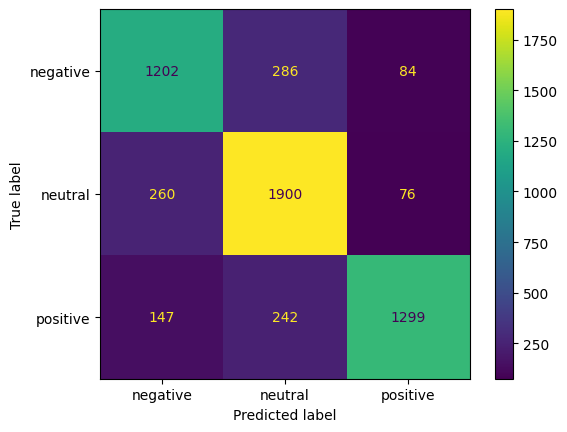

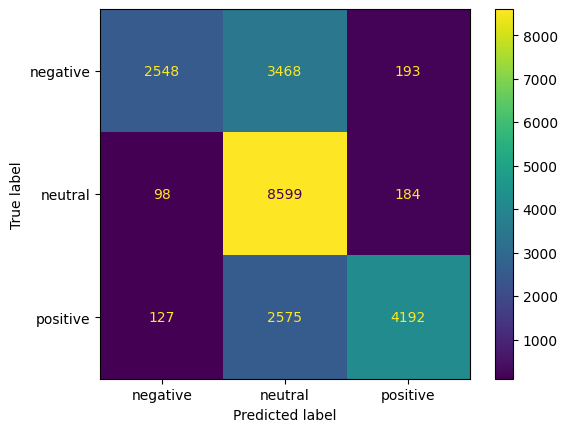

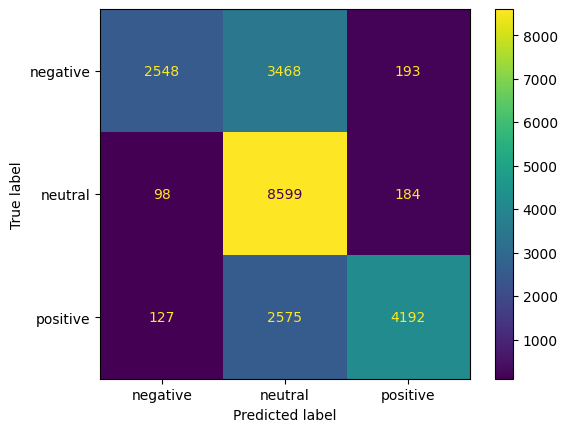

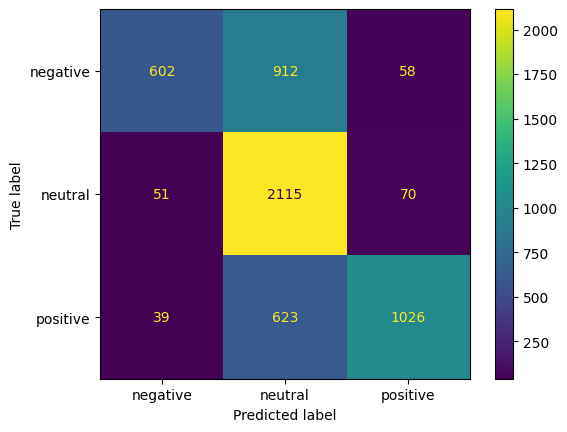

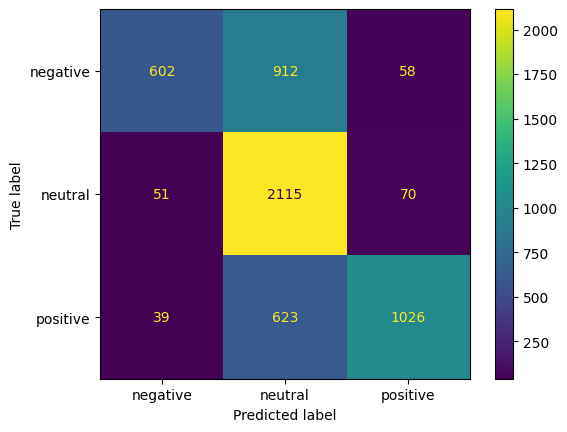

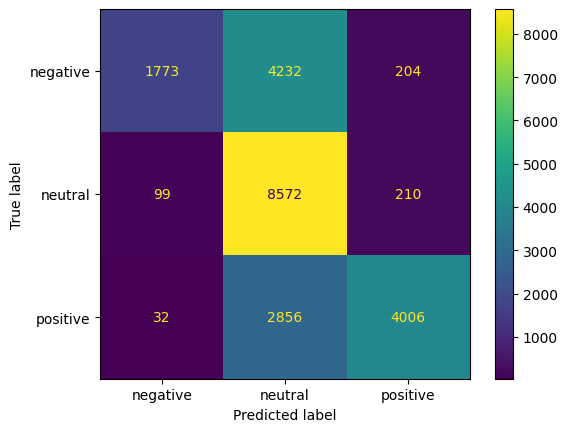

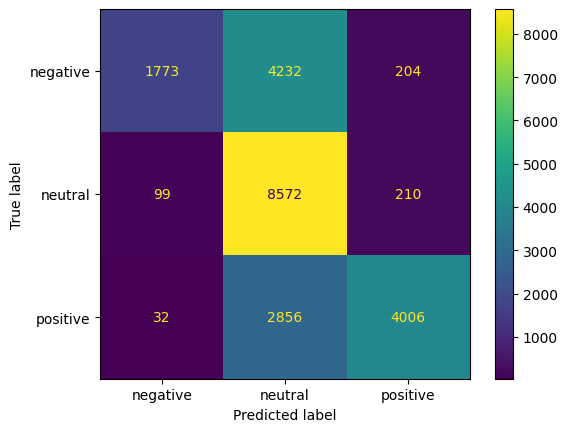

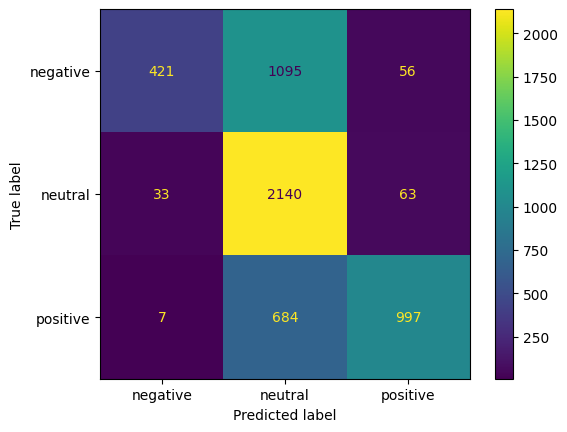

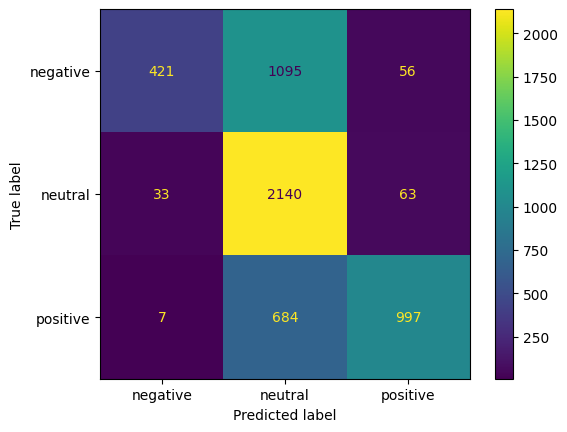

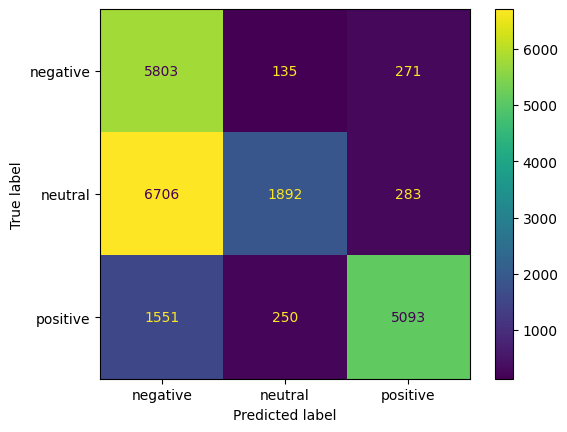

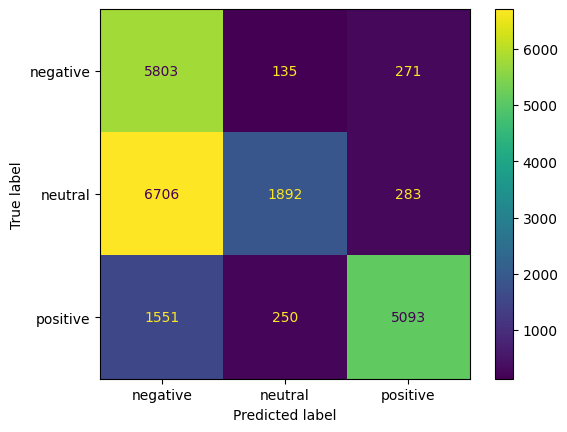

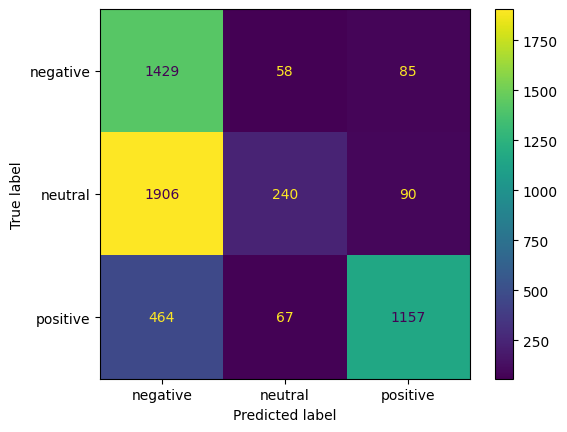

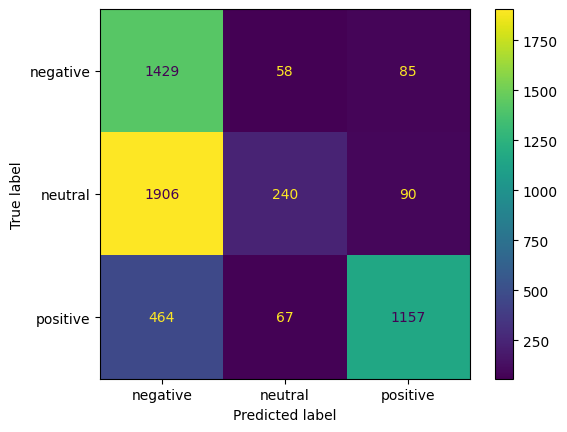

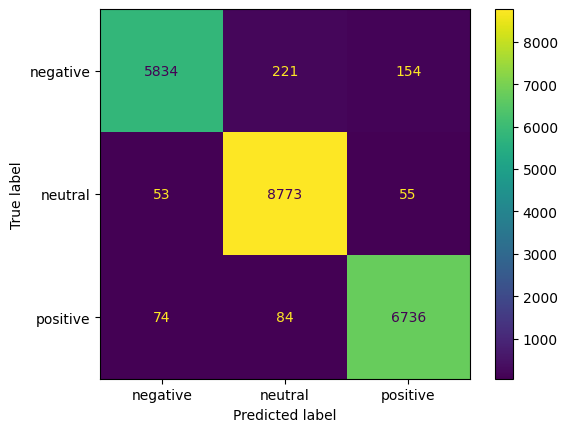

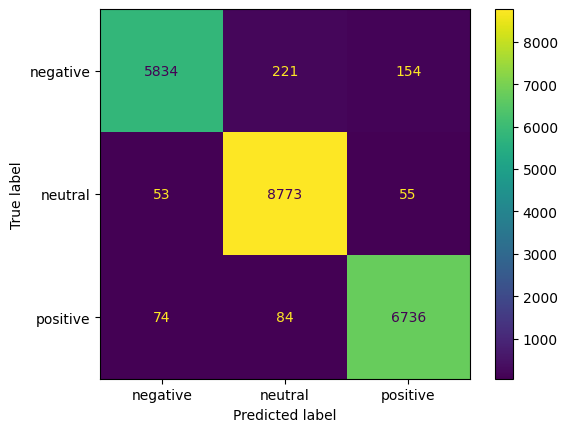

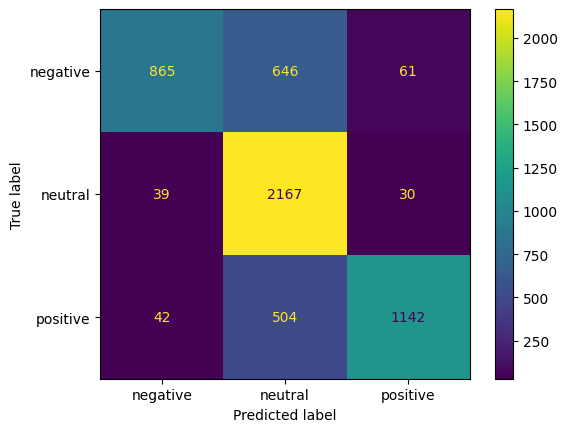

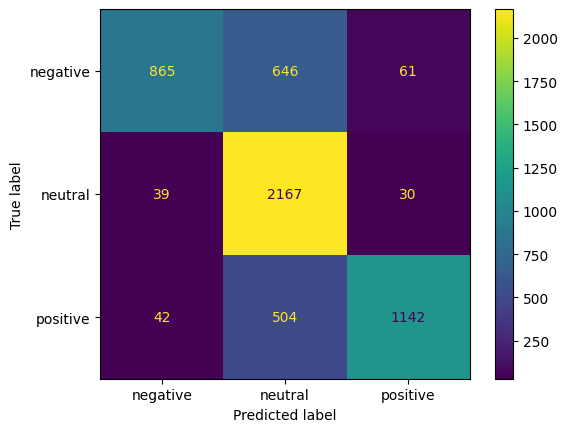

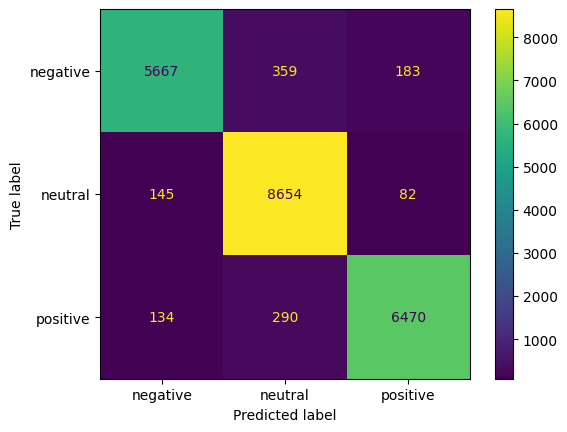

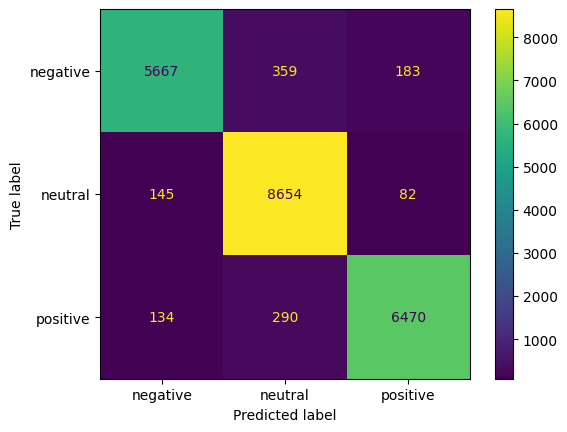

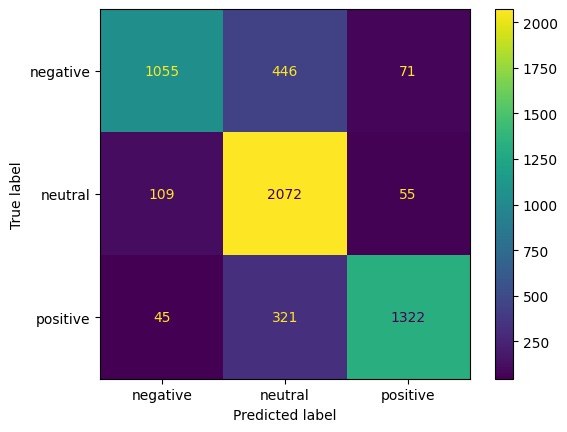

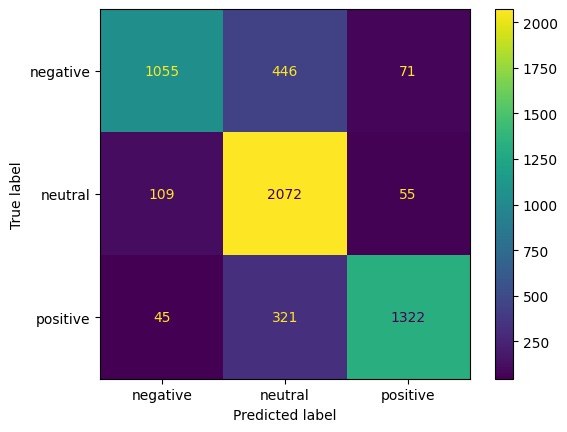

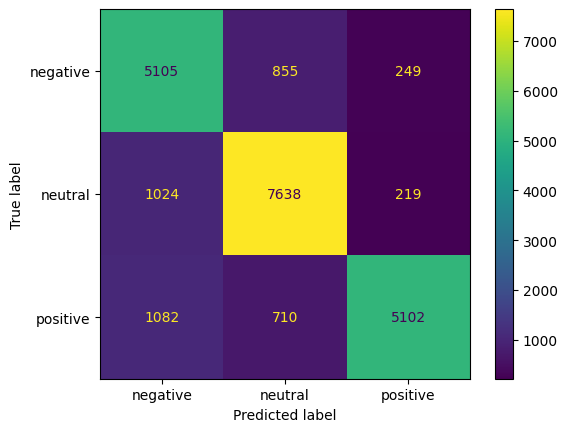

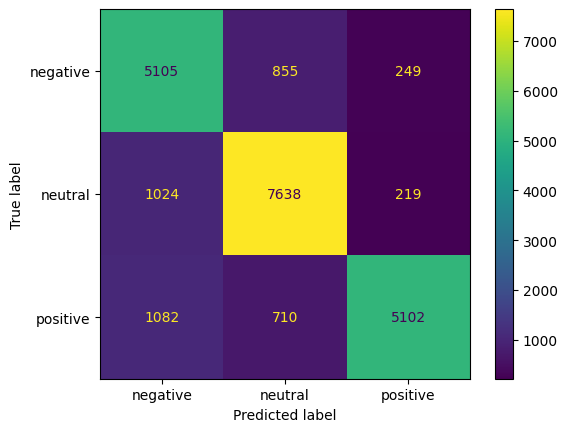

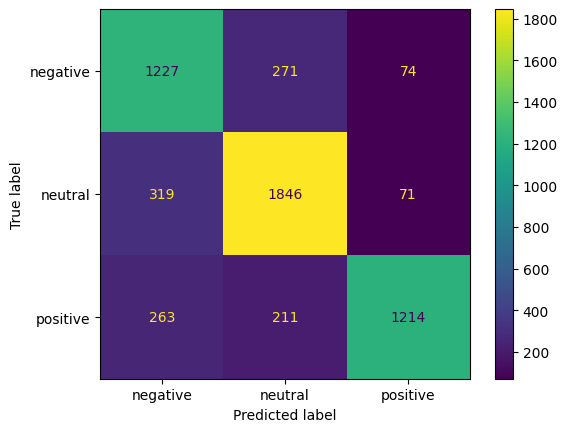

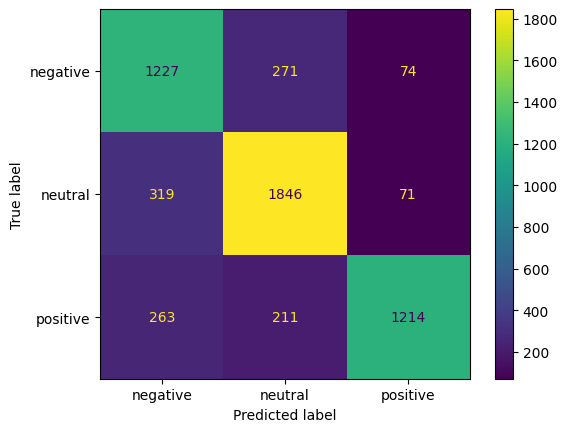

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import lightgbm as lgb
import xgboost as xgb

# Models
nb_model = MultinomialNB()
svm_model = LinearSVC()
lr_model = LogisticRegression()
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()
gb_model = GradientBoostingClassifier()
ada_model = AdaBoostClassifier()
knn_model = KNeighborsClassifier()
poly_svc_model = SVC(kernel='poly')
rbf_svc_model = SVC(kernel='rbf')
lgb_model = lgb.LGBMClassifier()

models = {
    "Naive Bayes": nb_model,
    "Linear SVM": svm_model,
    "Logistic Regression": lr_model,
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model,
    "AdaBoost": ada_model,
    "KNN": knn_model,
    "Poly SVC": poly_svc_model,
    "RBF SVC": rbf_svc_model,
    "LightGBM": lgb_model
}

# Evaluating models
for name, model in models.items():
    print(name + ":")
    evaluate_model(model, X_train, X_test, y_train, y_test)
    print("\n")


# Accuracy Plots

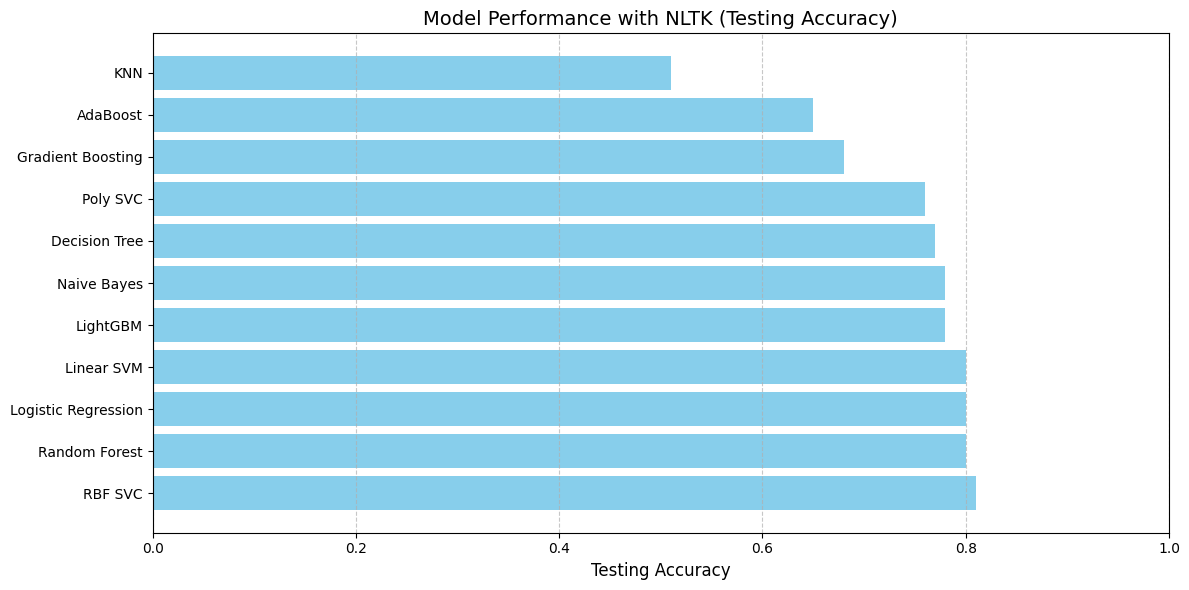

In [12]:
import matplotlib.pyplot as plt

# Model names and corresponding metrics
models = [
    "Naive Bayes",
    "Linear SVM",
    "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "Gradient Boosting",
    "AdaBoost",
    "KNN",
    "Poly SVC",
    "RBF SVC",
    "LightGBM"
]

testing_accuracies = [
    0.78,  # Naive Bayes
    0.80,  # Linear SVM
    0.80,  # Logistic Regression
    0.77,  # Decision Tree
    0.80,  # Random Forest
    0.68,  # Gradient Boosting
    0.65,  # AdaBoost
    0.51,  # KNN
    0.76,  # Poly SVC
    0.81,  # RBF SVC
    0.78   # LightGBM
]

# Sort model names and testing accuracies based on testing accuracies
sorted_data = sorted(zip(models, testing_accuracies), key=lambda x: x[1])

sorted_models = [x[0] for x in sorted_data]
sorted_testing_accuracies = [x[1] for x in sorted_data]

# Create a bar plot in ascending order of testing accuracies
plt.figure(figsize=(12, 6))
plt.barh(sorted_models, sorted_testing_accuracies, color='skyblue')
plt.xlabel('Testing Accuracy', fontsize=12)
plt.title('Model Performance with NLTK (Testing Accuracy)', fontsize=14)
plt.xlim(0, 1)  # Set the x-axis limit to range from 0 to 1 (assuming accuracy range)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add gridlines to x-axis
plt.gca().invert_yaxis()  # Invert y-axis to display models from top to bottom
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Show the plot
plt.show()

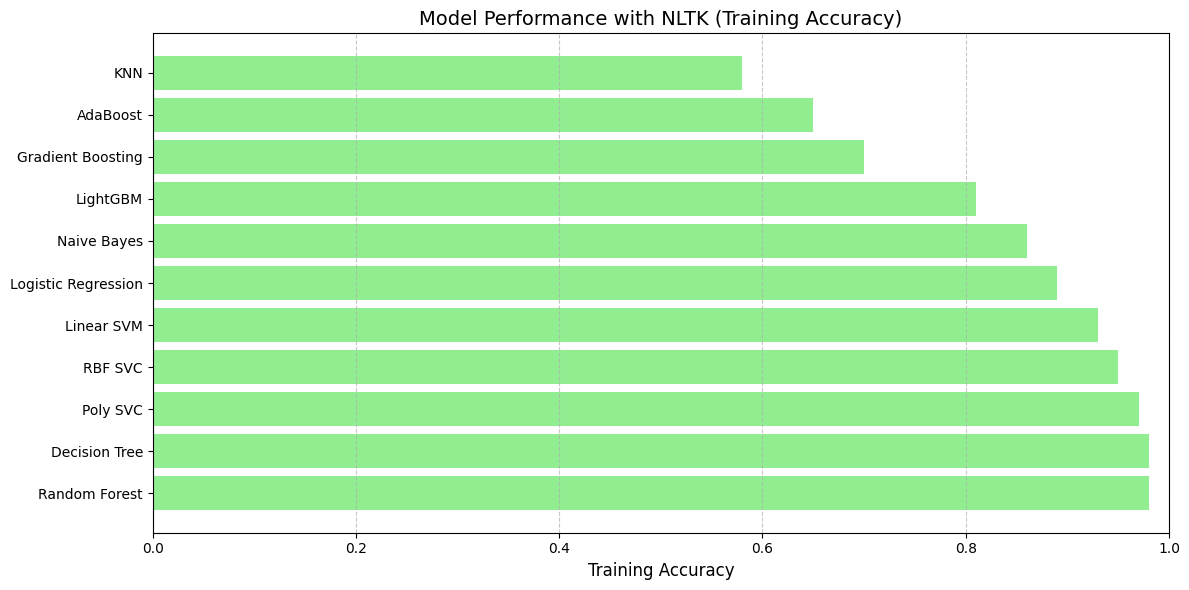

In [13]:
# Model names and corresponding metrics
models = [
    "Naive Bayes",
    "Linear SVM",
    "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "Gradient Boosting",
    "AdaBoost",
    "KNN",
    "Poly SVC",
    "RBF SVC",
    "LightGBM"
]

training_accuracies = [
    0.86,  # Naive Bayes
    0.93,  # Linear SVM
    0.89,  # Logistic Regression
    0.98,  # Decision Tree
    0.98,  # Random Forest
    0.70,  # Gradient Boosting
    0.65,  # AdaBoost
    0.58,  # KNN
    0.97,  # Poly SVC
    0.95,  # RBF SVC
    0.81   # LightGBM
]

# Sort model names and training accuracies based on training accuracies
sorted_data = sorted(zip(models, training_accuracies), key=lambda x: x[1])

sorted_models = [x[0] for x in sorted_data]
sorted_training_accuracies = [x[1] for x in sorted_data]

# Create a bar plot in ascending order of training accuracies
plt.figure(figsize=(12, 6))
plt.barh(sorted_models, sorted_training_accuracies, color='lightgreen')
plt.xlabel('Training Accuracy', fontsize=12)
plt.title('Model Performance with NLTK (Training Accuracy)', fontsize=14)
plt.xlim(0, 1)  # Set the x-axis limit to range from 0 to 1 (assuming accuracy range)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add gridlines to x-axis
plt.gca().invert_yaxis()  # Invert y-axis to display models from top to bottom
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Show the plot
plt.show()